# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# Data Preprocessing

## Read Data

In [2]:
# read the raw data
# Note: The raw data contains some unlabeled data
raw_train = pd.read_csv("Data/raw-data/train.csv")
raw_valid = pd.read_csv("Data/raw-data/valid.csv")
raw_test = pd.read_csv("Data/raw-data/test.csv")

## Text Preprocessing to Get Clean Data: Lemmatization

In [3]:
def text_preprocess(doc, stop_words, lammatiser):
    doc = str(doc) # change the doc to string
    doc = re.sub(r'\.(?=\w)','. ', doc)  # Add a space after fullstop without a space
    doc = re.sub(r'[^A-z\s]', ' ', doc) # remove everything except A-z characters and white space
    doc = re.sub(r'\s+', ' ', doc) # in case there are more than 1 white space, replace it with 1 white space
    doc = doc.lower()
    tokens = word_tokenize(doc) # tokenize these raw text
    tokens = [w for w in tokens if not w in stop_words] # remove all the stop words
    lammatisation = [lammatiser.lemmatize(w) for w in tokens]
    return ' '.join(lammatisation)

# set doc=JD_train, stop_word = ntlk.stopwords, lammatiser = ntlk.WordNetLemmatizer()
JD_train = raw_train['requirements_and_role']
JD_valid = raw_valid['requirements_and_role']
JD_test = raw_test['requirements_and_role']
stop_words = set(stopwords.words('english'))
lammatiser = WordNetLemmatizer()

# Loop through each job description, preprocess, and append the output to cleaned_JD
cleaned_JD_train = []
for jd in JD_train:
    cleaned_JD_train.append(text_preprocess(jd, stop_words, lammatiser))

cleaned_JD_valid = []
for jd in JD_valid:
    cleaned_JD_valid.append(text_preprocess(jd, stop_words, lammatiser))

cleaned_JD_test = []
for jd in JD_test:
    cleaned_JD_test.append(text_preprocess(jd, stop_words, lammatiser))

# Append this cleaned JD to df
raw_train['cleaned_JD_train'] = cleaned_JD_train
raw_valid['cleaned_JD_valid'] = cleaned_JD_valid
raw_test['cleaned_JD_test'] = cleaned_JD_test

# Create Bigrams and Trigrams

In [4]:
bi_train = []
for jd in cleaned_JD_train:
    # create bigram
    bigram = list(ngrams(jd.split(),2))
    # remove the list of list structure
    bigram = [' '.join(bi) for bi in bigram]
    bi_train.append(bigram)

tri_train = []
for jd in cleaned_JD_train:
    # create bigram
    trigram = list(ngrams(jd.split(),3))
    # remove the list of list structure
    trigram = [' '.join(tri) for tri in trigram]
    tri_train.append(trigram)

# Seperate Job Descriptions According to Salary Bins

High Salary Job if in bin 8,9; Low Salary Job if in bin 0,1

In [5]:
# extract JD for high salary jobs and low salary jobs
high_sal_uni = []
low_sal_uni = []
high_sal_bi = []
low_sal_bi = []
high_sal_tri = []
low_sal_tri = []
# seperate JD into high salary jobs and low salary jobs
for i in range(len(raw_train['requirements_and_role'])):

    if raw_train['salary_bin'][i] >= 8:
        high_sal_uni += cleaned_JD_train[i].split()
        high_sal_bi += bi_train[i]
        high_sal_tri += tri_train[i]

    elif raw_train['salary_bin'][i] <= 1:
        low_sal_uni += cleaned_JD_train[i].split()
        low_sal_bi += bi_train[i]
        low_sal_tri += tri_train[i]

# Calculate the Log Odds Ratio 

to Identify the Important Words, Bigrams and Trigrams for both High Salary and Low Salary Jobs

##  Calculate the probability that a word/bigram/trigram appears in a positive/negative review

P(word in high salary jobs) = # high salary jobs containing this word / # high salary jobs

We only retain the words that occurs in both high salary job descriptions and low salary job descriptions

In [6]:
# Numerator: df containing count of word/bigram/trigram occurance grouped by words/bigram/trigram
# change it to df, groupby and then count the occurance
high_sal_word_count_uni = pd.DataFrame({'Unigram':high_sal_uni,'count':np.array(1)}).groupby('Unigram').count()
high_sal_word_count_bi = pd.DataFrame({'Bigram':high_sal_bi,'count':np.array(1)}).groupby('Bigram').count()
high_sal_word_count_tri = pd.DataFrame({'Trigram':high_sal_tri,'count':np.array(1)}).groupby('Trigram').count()
low_sal_word_count_uni = pd.DataFrame({'Unigram':low_sal_uni,'count':np.array(1)}).groupby('Unigram').count()
low_sal_word_count_bi = pd.DataFrame({'Bigram':low_sal_bi,'count':np.array(1)}).groupby('Bigram').count()
low_sal_word_count_tri = pd.DataFrame({'Trigram':low_sal_tri,'count':np.array(1)}).groupby('Trigram').count()

# Denominator: constant
total_high_sal_uni = len(high_sal_uni)
total_high_sal_bi = len(high_sal_bi)
total_high_sal_tri = len(high_sal_tri)
total_low_sal_uni = len(low_sal_uni)
total_low_sal_bi = len(low_sal_bi)
total_low_sal_tri = len(low_sal_tri)

# calculate the probability of occuring for the bigram
# Note: we only retain the word/bigram/trigram that occur simultaneously in the high salary JD and low salary JD
# Each p is a dictionary comprehension with key = word/bigram/trigram, value = probability of occurance
p_high_uni = {i:(high_sal_word_count_uni.loc[i][0]/ total_high_sal_uni) 
              for i in high_sal_word_count_uni.index if i in low_sal_word_count_uni.index}
p_high_bi = {i:(high_sal_word_count_bi.loc[i][0]/ total_high_sal_bi) 
              for i in high_sal_word_count_bi.index if i in low_sal_word_count_bi.index}
p_high_tri = {i:(high_sal_word_count_tri.loc[i][0]/ total_high_sal_tri) 
              for i in high_sal_word_count_tri.index if i in low_sal_word_count_tri.index}

p_low_uni = {i:(low_sal_word_count_uni.loc[i][0]/ total_low_sal_uni) 
              for i in low_sal_word_count_uni.index if i in high_sal_word_count_uni.index}
p_low_bi = {i:(low_sal_word_count_bi.loc[i][0]/ total_low_sal_bi) 
              for i in low_sal_word_count_bi.index if i in high_sal_word_count_bi.index}
p_low_tri = {i:(low_sal_word_count_tri.loc[i][0]/ total_low_sal_tri) 
              for i in low_sal_word_count_tri.index if i in high_sal_word_count_tri.index}

## Calculate Odds using Prob

Odds is just another representation of probability

In [7]:
# calculate odds
odds_high_uni = {i : p_high_uni[i] / (1 - p_high_uni[i]) 
                 for i in p_high_uni if (p_high_uni[i] != 0 and p_high_uni[i] != 1)}
odds_high_bi = {i : p_high_bi[i] / (1 - p_high_bi[i]) 
                 for i in p_high_bi if (p_high_bi[i] != 0 and p_high_bi[i] != 1)}
odds_high_tri = {i : p_high_tri[i] / (1 - p_high_tri[i]) 
                 for i in p_high_tri if (p_high_tri[i] != 0 and p_high_tri[i] != 1)}

odds_low_uni = {i : p_low_uni[i] / (1 - p_low_uni[i]) 
                 for i in p_low_uni if (p_low_uni[i] != 0 and p_low_uni[i] != 1)}
odds_low_bi = {i : p_low_bi[i] / (1 - p_low_bi[i]) 
                 for i in p_low_bi if (p_low_bi[i] != 0 and p_low_bi[i] != 1)}
odds_low_tri = {i : p_low_tri[i] / (1 - p_low_tri[i]) 
                 for i in p_low_tri if (p_low_tri[i] != 0 and p_low_tri[i] != 1)}

## Calculate Odds Ratio using Odds high salary and Odds low salary

or = o_high / or_low

In [8]:
# calculate odds ratio
odds_ratio_uni = {}
for i in odds_low_uni:
    odds_ratio_uni[i] = odds_high_uni[i] / odds_low_uni[i]

odds_ratio_bi = {}
for i in odds_low_bi:
    odds_ratio_bi[i] = odds_high_bi[i] / odds_low_bi[i]

odds_ratio_tri = {}
for i in odds_low_tri:
    odds_ratio_tri[i] = odds_high_tri[i] / odds_low_tri[i]

## Calculate Log Odds Ratio

Log is the monotonic transformation so does not change the order of Odds Ratios but make it more compact

In [9]:
# calculate log odds ratio
log_odds_ratio_uni = {i:round(math.log10(odds_ratio_uni[i]),4) for i in odds_ratio_uni}
log_odds_ratio_bi = {i:round(math.log10(odds_ratio_bi[i]),4) for i in odds_ratio_bi}
log_odds_ratio_tri = {i:round(math.log10(odds_ratio_tri[i]),4) for i in odds_ratio_tri}

# Graph the Log Odds Ratio on three Histograms

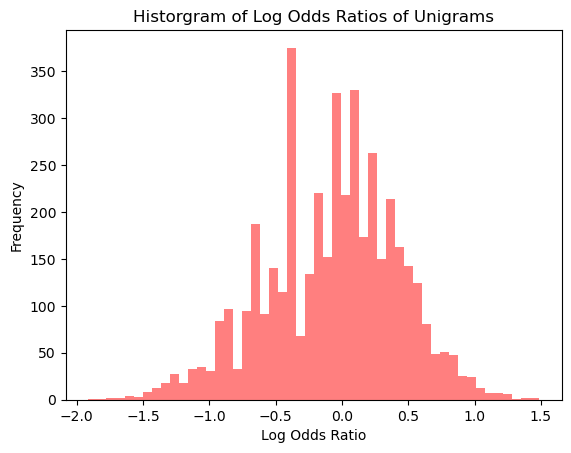

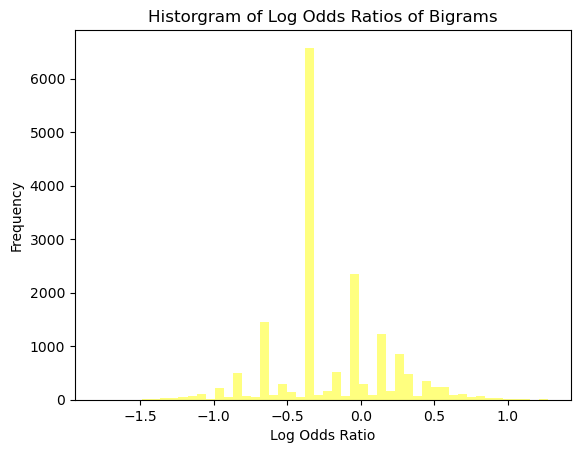

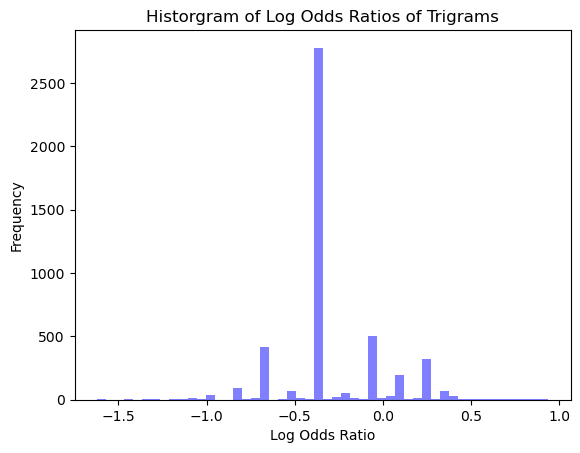

In [10]:
# Define the word/bigram/trigram and log odds ratios that we want to graph
unigrams = log_odds_ratio_uni.keys()
LOR_uni = log_odds_ratio_uni.values()
bigrams = log_odds_ratio_bi.keys()
LOR_bi = log_odds_ratio_bi.values()
trigrams = log_odds_ratio_tri.keys()
LOR_tri = log_odds_ratio_tri.values()

# histogram unigram
plt.figure()
plt.hist(LOR_uni, alpha=0.5, color='red',bins=50)
plt.title('Historgram of Log Odds Ratios of Unigrams')
plt.xlabel('Log Odds Ratio')
plt.ylabel('Frequency')
plt.savefig("hist_LOR_uni.png", dpi=100, format="png")
plt.show()

# histogram bigram
plt.figure()
plt.hist(LOR_bi, alpha=0.5, color='yellow',bins=50)
plt.title('Historgram of Log Odds Ratios of Bigrams')
plt.xlabel('Log Odds Ratio')
plt.ylabel('Frequency')
plt.savefig("hist_LOR_bi.png", dpi=100, format="png")
plt.show()

# histogram trigram
plt.figure()
plt.hist(LOR_tri, alpha=0.5, color='blue',bins=50)
plt.title('Historgram of Log Odds Ratios of Trigrams')
plt.xlabel('Log Odds Ratio')
plt.ylabel('Frequency')
plt.savefig("hist_LOR_tri.png", dpi=100, format="png")
plt.show()

# Graph 10 most important words/bigrams/trigrams for high/low salary jobs

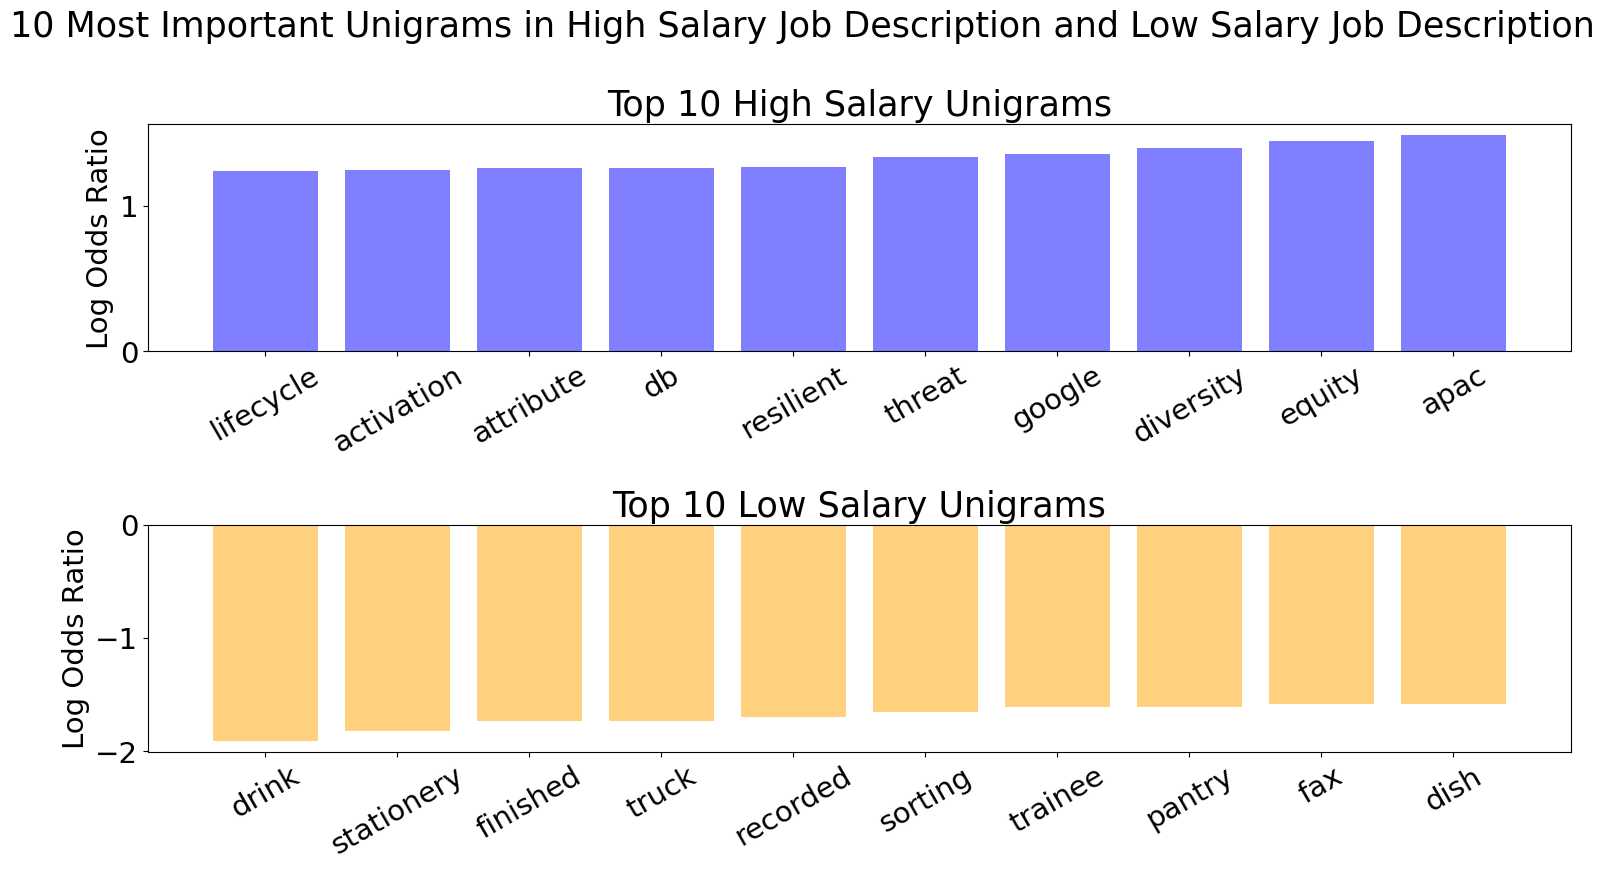

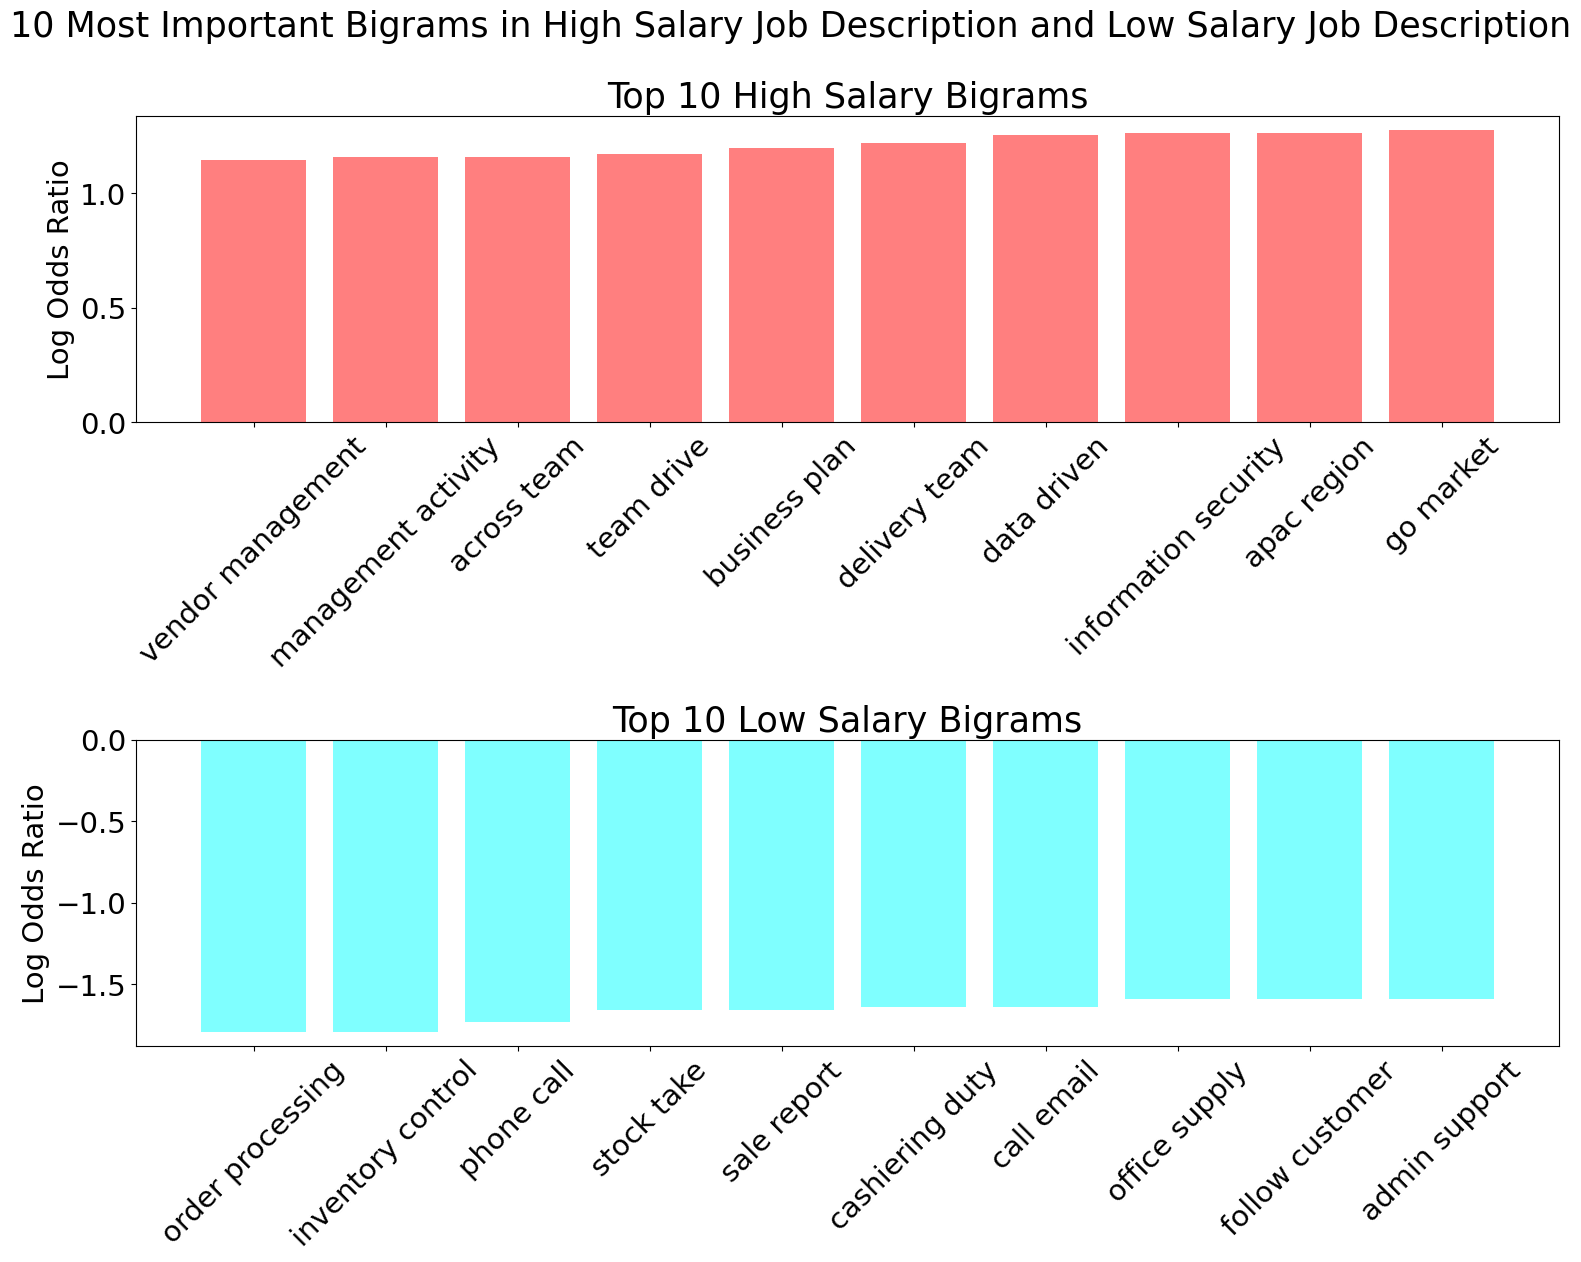

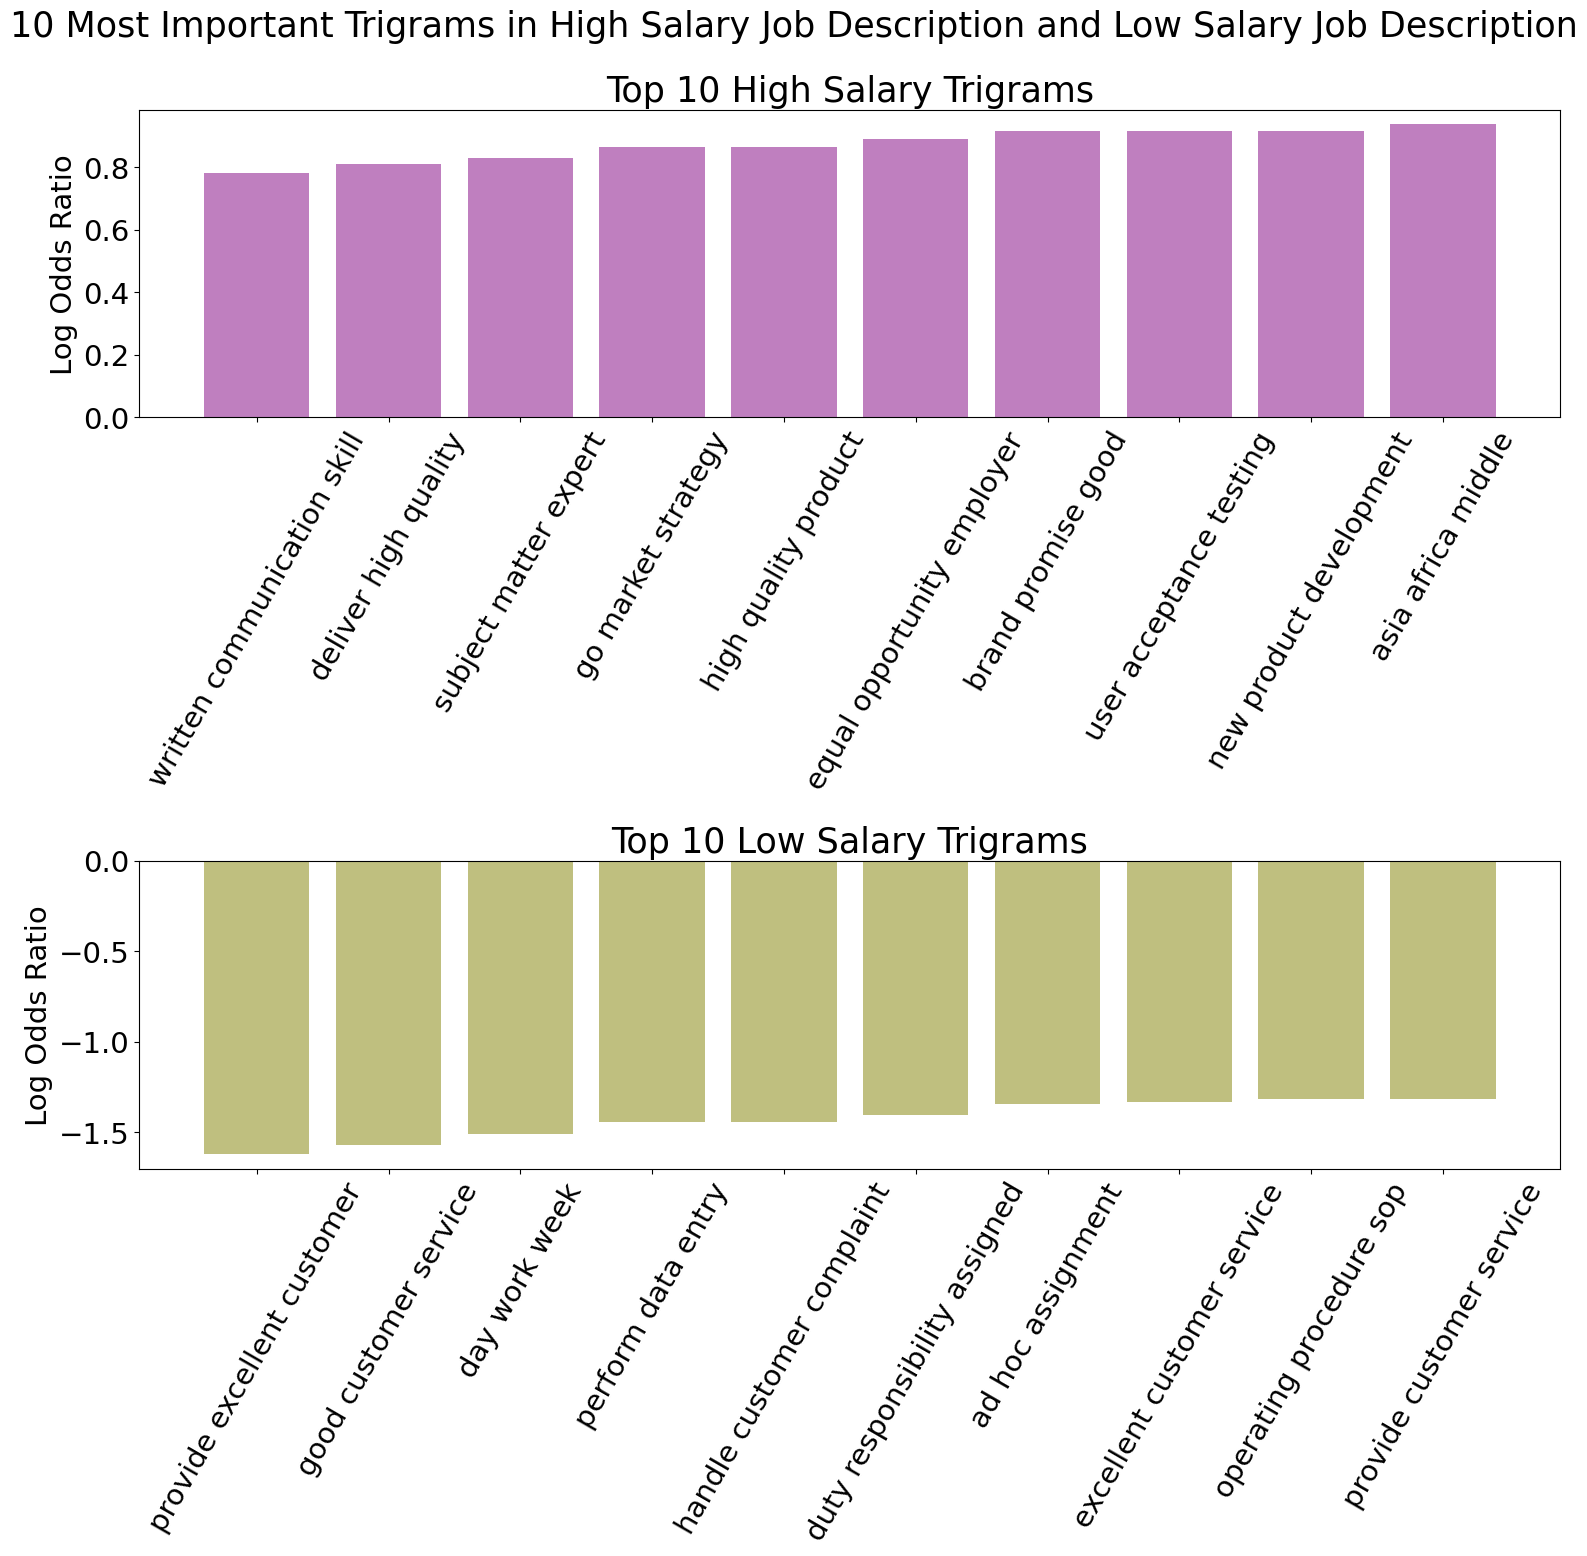

In [11]:
# create a dataframe to sort values of LOR
df_uni = pd.DataFrame({'Unigram':unigrams,'log_odds_ratio':LOR_uni})
df_uni = df_uni.sort_values(by='log_odds_ratio')
df_bi = pd.DataFrame({'Bigram':bigrams,'log_odds_ratio':LOR_bi})
df_bi = df_bi.sort_values(by='log_odds_ratio')
df_tri = pd.DataFrame({'Trigram':trigrams,'log_odds_ratio':LOR_tri})
df_tri = df_tri.sort_values(by='log_odds_ratio')

# change font size
font = {'size'   : 21}

plt.rc('font', **font)
# top 10 words
fig, ax = plt.subplots(2, figsize=(16,9))
fig.suptitle('10 Most Important Unigrams in High Salary Job Description and Low Salary Job Description')

ax[0].bar(df_uni['Unigram'][-10:],df_uni['log_odds_ratio'][-10:], color = 'blue',alpha=0.5)
ax[0].set_title('Top 10 High Salary Unigrams')
ax[0].set_xticklabels(df_uni['Unigram'][-10:],rotation = 30)
ax[0].set_ylabel('Log Odds Ratio')

ax[1].bar(df_uni['Unigram'][:10],df_uni['log_odds_ratio'][:10], color = 'orange',alpha=0.5)
ax[1].set_title('Top 10 Low Salary Unigrams')
ax[1].set_xticklabels(df_uni['Unigram'][:10],rotation = 30)
ax[1].set_ylabel('Log Odds Ratio')


fig.tight_layout()
plt.savefig("top10_uni.png", dpi=100, format="png")
plt.show()

# top 10 words
fig, ax = plt.subplots(2, figsize=(16,13))
fig.suptitle('10 Most Important Bigrams in High Salary Job Description and Low Salary Job Description')

ax[0].bar(df_bi['Bigram'][-10:],df_bi['log_odds_ratio'][-10:], color = 'red',alpha=0.5)
ax[0].set_title('Top 10 High Salary Bigrams')
ax[0].set_xticklabels(df_bi['Bigram'][-10:],rotation = 45)
ax[0].set_ylabel('Log Odds Ratio')

ax[1].bar(df_bi['Bigram'][:10],df_bi['log_odds_ratio'][:10], color = 'cyan',alpha=0.5)
ax[1].set_title('Top 10 Low Salary Bigrams')
ax[1].set_xticklabels(df_bi['Bigram'][:10],rotation = 45)
ax[1].set_ylabel('Log Odds Ratio')


fig.tight_layout()
plt.savefig("top10_bi.png", dpi=100, format="png")
plt.show()

# top 10 words
fig, ax = plt.subplots(2,figsize=(16,16))
fig.suptitle('10 Most Important Trigrams in High Salary Job Description and Low Salary Job Description')

ax[0].bar(df_tri['Trigram'][-10:],df_tri['log_odds_ratio'][-10:], color = 'purple',alpha=0.5)
ax[0].set_title('Top 10 High Salary Trigrams')
ax[0].set_xticklabels(df_tri['Trigram'][-10:],rotation = 60)
ax[0].set_ylabel('Log Odds Ratio')

ax[1].bar(df_tri['Trigram'][:10],df_tri['log_odds_ratio'][:10], color = 'olive',alpha=0.5)
ax[1].set_title('Top 10 Low Salary Trigrams')
ax[1].set_xticklabels(df_tri['Trigram'][:10],rotation = 60)
ax[1].set_ylabel('Log Odds Ratio')


fig.tight_layout()
plt.savefig("top10_tri.png", dpi=100, format="png")
plt.show()


# Seperate data in Labelled and Unlabelled Data

In [12]:
# unlabelled if label is null, labelled if label is not null
unlab_cut = ((raw_train.salary_bin.isnull()) |
     (raw_train.mean_salary.isnull()))

unlab_raw_train = raw_train[unlab_cut == True].reset_index(drop = True)
lab_raw_train = raw_train[unlab_cut == False].reset_index(drop = True)

#print the head and shape of labelled and unlabelled data
print('Print the Head and Shape of Unlabelled Training Data')
display(unlab_raw_train.head())
print(unlab_raw_train.shape)

print('\nPrint the Head and Shape of Labelled Training Data')
display(lab_raw_train.head())
print(lab_raw_train.shape)

# For the validation Dataset
unlab_cut = ((raw_valid.salary_bin.isnull()) |
     (raw_valid.mean_salary.isnull()))

lab_raw_valid = raw_valid[unlab_cut == False].reset_index(drop = True)

print('\nPrint the Head and Shape of Labelled Validation Data')
display(lab_raw_valid.head())
print(lab_raw_valid.shape)

# Note: All the data in test dataset is unlabelled


Print the Head and Shape of Unlabelled Training Data


,job_id,requirements_and_role,salary_bin,mean_salary,gender_code,cleaned_JD_train
0,JOB-2019-0002334,research development various fundamental cutti...,NaN,NaN,NaN,research development various fundamental cutti...
1,JOB-2019-0002654,established 1981 school electrical electronic ...,NaN,NaN,NaN,established school electrical electronic engin...
2,JOB-2019-0011072,perform administrative support order fulfillme...,NaN,NaN,NaN,perform administrative support order fulfillme...
3,JOB-2019-0014833,responsibilities oversee execution events prod...,NaN,NaN,NaN,responsibility oversee execution event product...
4,JOB-2019-0009048,linkedin built help professionals achieve care...,NaN,NaN,NaN,linkedin built help professional achieve caree...


(5902, 6)

Print the Head and Shape of Labelled Training Data


,job_id,requirements_and_role,salary_bin,mean_salary,gender_code,cleaned_JD_train
0,JOB-2019-0015706,role purpose role lead finance team asia offic...,9.0,20833.333333,2.0,role purpose role lead finance team asia offic...
1,JOB-2019-0013345,lead cim team source procure implement maintai...,9.0,10000.000000,2.0,lead cim team source procure implement maintai...
2,JOB-2019-0011784,responsibilities lecturer contributions go bey...,4.0,4500.000000,2.0,responsibility lecturer contribution go beyond...
3,JOB-2019-0013898,preparation welcome kits current savings accou...,6.0,6000.000000,2.0,preparation welcome kit current saving account...
4,JOB-2019-0000435,full time rto 18 months,3.0,3750.000000,2.0,full time rto month


(8000, 6)

Print the Head and Shape of Labelled Validation Data


,job_id,requirements_and_role,salary_bin,mean_salary,gender_code,cleaned_JD_valid
0,JOB-2019-0000007,leads manages team architectural personnel pos...,8,9000.0,2,lead manages team architectural personnel poss...
1,JOB-2019-0000009,responsibilities take ownership conducting res...,8,8000.0,2,responsibility take ownership conducting resea...
2,JOB-2019-0000011,supervisors oversee day day running centre res...,2,2950.0,0,supervisor oversee day day running centre resp...
3,JOB-2019-0000013,mentor junior teachers take lead assigned proj...,3,3250.0,0,mentor junior teacher take lead assigned proje...
4,JOB-2019-0000016,position summary customer success specialist c...,6,5500.0,0,position summary customer success specialist c...


(1737, 6)


# Tf-Idf Transformer

In [13]:
# define a function for tfidf for the convenience of changing: 
# input text (in training set, validation and test); max features needed; and ngrams
def tfidf(cleanedText_train, cleanedText_test, maxFeatures = None, ngram = 1):
    '''
    This function take string form cleaned Text and process it to Tf-Idf sparse matrix
    '''
    vectorizer = TfidfVectorizer(max_features = maxFeatures,ngram_range = (ngram,ngram))
    trained_vec = vectorizer.fit(cleanedText_train)
    tfidf = trained_vec.transform(cleanedText_test)
    # check the names of terms
    #display(vectorizer.get_feature_names_out())
    return tfidf 


# Select Best Hyper Parameters

## Select best k and best max_features in KNN

In [14]:
def cv_grid_search_KNN(cleanedText_train, cleanedText_test,y_test, max_feature_lis, max_k, ngrams=1):
    '''
    This function grid search on max_features of tfidf and different algo parameters
    Could facilitate ngram tfidf
    take text as input and output three lists
    '''
    # some list to contain the hyperparameter crosss validation selection result
    # best k for each max_feature numbers
    best_k = []
    # accuracy score using best k for each max_feature numbers
    best_k_acc = []
    # accuracy list of different k under current max_feature numbers. In list of list(array)
    acc_lis = []
    
    # Use KNN with Euclidean Distance
    knn = KNeighborsClassifier(p=2)

    # Grid Search the hyper parameter K with max k=50
    k_range = list(np.arange(1,max_k,2))
    param_grid = dict(n_neighbors=k_range)

    for max_fea in max_feature_lis:
        X = tfidf(cleanedText_train, cleanedText_test, maxFeatures = max_fea,ngram=ngrams)
        # 10 fold cross validation, use accuracy as metric since this is balanced dataset
        grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
        grid_search=grid.fit(X, y_test)

        k = grid_search.best_params_
        best_k.append(k)
        k_acc = grid_search.best_score_
        best_k_acc.append(k_acc)
        test_acc_lis = grid_search.cv_results_['mean_test_score']
        acc_lis.append(test_acc_lis)

    return best_k, best_k_acc, acc_lis


In [15]:
# Using train dataset to pick the best hyperparameter
cleanedText_train = lab_raw_train['cleaned_JD_train']
cleanedText_valid = lab_raw_valid['cleaned_JD_valid']
y_valid = lab_raw_valid['salary_bin']
y_train = lab_raw_train['salary_bin']
# set the max_feature parameter in tfidf creation
# Note: The validation dataset only have 5735 features
max_feature_lis = [500,1000,2000,None]
# set max k that we want to try in KNN algorithm 
max_k = 300


# choose k and max_features for unigrams in use validation set
best_k_uni, best_k_acc_uni, acc_lis_uni = cv_grid_search_KNN(
    cleanedText_train,cleanedText_valid, y_valid, max_feature_lis, max_k, ngrams=1)

display('\n Unigram Validation Set:',best_k_uni, '\n',best_k_acc_uni)

# choose k and max_features for unigrams in use training set
best_k_uni_train, best_k_acc_uni_train, acc_lis_uni_train = cv_grid_search_KNN(
    cleanedText_train,cleanedText_train, y_train, max_feature_lis, max_k, ngrams=1)

display('\n Unigram Training Set:',best_k_uni_train, '\n',best_k_acc_uni_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


'\n Unigram Validation Set:'

[{'n_neighbors': 189},
 {'n_neighbors': 187},
 {'n_neighbors': 207},
 {'n_neighbors': 195}]

'\n'

[0.2297255996279317,
 0.23086838083848252,
 0.22739685070759416,
 0.22973888778154272]

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


'\n Unigram Training Set:'

[{'n_neighbors': 237},
 {'n_neighbors': 73},
 {'n_neighbors': 79},
 {'n_neighbors': 49}]

'\n'

[0.23374999999999999, 0.23812499999999998, 0.242, 0.24312500000000004]

In [16]:
# choose k and max_features for unigrams
best_k_bi, best_k_acc_bi, acc_lis_bi = cv_grid_search_KNN(
    cleanedText_train,cleanedText_valid, y_valid, max_feature_lis, max_k, ngrams=2)

display('Bigram Validation Set:',best_k_bi,best_k_acc_bi)

best_k_bi_train, best_k_acc_bi_train, acc_lis_bi_train = cv_grid_search_KNN(
    cleanedText_train,cleanedText_train, y_train, max_feature_lis, max_k, ngrams=2)

display('Bigram Validation Set:',best_k_bi_train,best_k_acc_bi_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


'Bigram Validation Set:'

[{'n_neighbors': 297},
 {'n_neighbors': 297},
 {'n_neighbors': 291},
 {'n_neighbors': 61}]

[0.13240316258055942,
 0.1617566939073816,
 0.18254933227028106,
 0.18995415587004189]

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


'Bigram Validation Set:'

[{'n_neighbors': 1},
 {'n_neighbors': 1},
 {'n_neighbors': 1},
 {'n_neighbors': 55}]

[0.15699999999999997, 0.15712500000000001, 0.153125, 0.23312500000000003]

In [17]:
# choose k and max_features for unigrams
best_k_tri, best_k_acc_tri, acc_lis_tri = cv_grid_search_KNN(
    cleanedText_train,cleanedText_valid, y_valid, max_feature_lis, max_k, ngrams=3)

display('Trigram Validation Set:',best_k_tri,best_k_acc_tri)

best_k_tri_train, best_k_acc_tri_train, acc_lis_tri_train = cv_grid_search_KNN(
    cleanedText_train,cleanedText_train, y_train, max_feature_lis, max_k, ngrams=3)

display('Trigram Training Set:',best_k_tri_train,best_k_acc_tri_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


'Trigram Validation Set:'

[{'n_neighbors': 9},
 {'n_neighbors': 1},
 {'n_neighbors': 1},
 {'n_neighbors': 1}]

[0.1381569330941466,
 0.13182844993688125,
 0.1335392997143047,
 0.12435386353066243]

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Fitting 10 folds for each of 150 candidates, totalling 1500 fits


'Trigram Training Set:'

[{'n_neighbors': 21},
 {'n_neighbors': 9},
 {'n_neighbors': 1},
 {'n_neighbors': 31}]

[0.15824999999999997, 0.15325000000000003, 0.15475, 0.17975000000000002]

### Save the data into CSV

In [18]:
# Since this code take long time to run, save the output of the code
df = pd.DataFrame({
    'Uni_k_val': best_k_uni,
    'Bi_k_val': best_k_bi,
    'Tri_k_val': best_k_tri,
    'Uni_k_train':best_k_uni_train,
    'Bi_k_train': best_k_bi_train,
    'Tri_k_train': best_k_tri_train,
    'Uni_acc_val': best_k_acc_uni,
    'Bi_acc_val': best_k_acc_bi,
    'Tri_acc_val': best_k_acc_tri,
    'Uni_acc_train': best_k_acc_uni_train,
    'Bi_acc_train': best_k_acc_bi_train,
    'Tri_acc_train': best_k_acc_tri_train,
    'Uni_meanTestScore_val': acc_lis_uni,
    'Bi_meanTestScore_val': acc_lis_bi,
    'Tri_meanTestScore_val': acc_lis_tri,
    'Uni_meanTestScore_train': acc_lis_uni_train,
    'Bi_meanTestScore_train':acc_lis_bi_train,
    'Tri_meanTestScore_train':acc_lis_tri_train,
})
df['Uni_meanTestScore_val'] = df['Uni_meanTestScore_val'].map(lambda x: ','.join(map(str, x)))
df['Bi_meanTestScore_val'] = df['Bi_meanTestScore_val'].map(lambda x: ','.join(map(str, x)))
df['Tri_meanTestScore_val'] = df['Tri_meanTestScore_val'].map(lambda x: ','.join(map(str, x)))
df['Uni_meanTestScore_train'] = df['Uni_meanTestScore_train'].map(lambda x: ','.join(map(str, x)))
df['Bi_meanTestScore_train'] = df['Bi_meanTestScore_train'].map(lambda x: ','.join(map(str, x)))
df['Tri_meanTestScore_train'] = df['Tri_meanTestScore_train'].map(lambda x: ','.join(map(str, x)))

df.to_csv('KNN_gridSearch.csv')

# When read the data, decode this string as list
#dfn = pd.read_csv("list.csv")
#dfn['alist'] = dfn['alist'].str.split(',')
#dfn['alist'] = dfn['alist'].map(lambda x: list(map(int, x)))

### Plot the k and accuracy

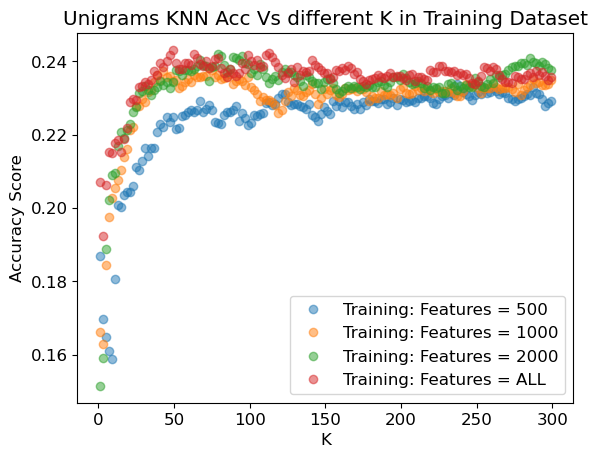

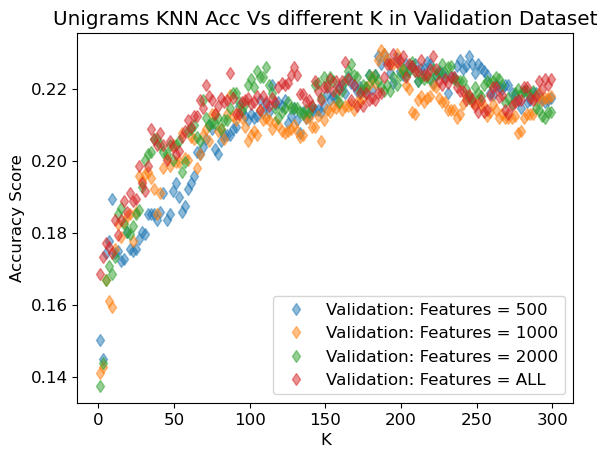

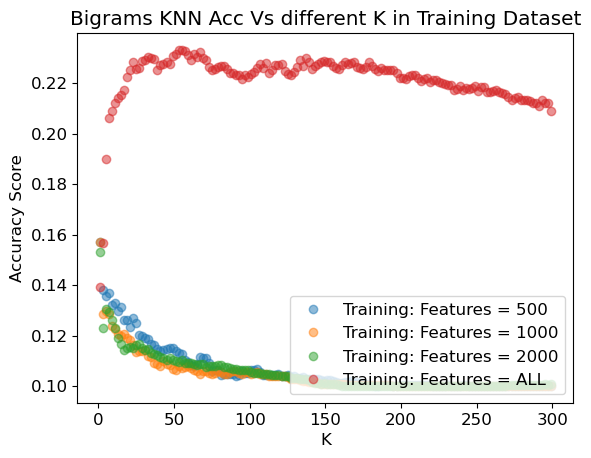

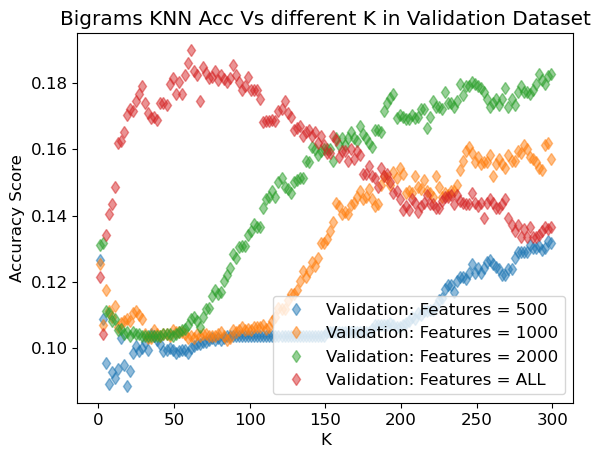

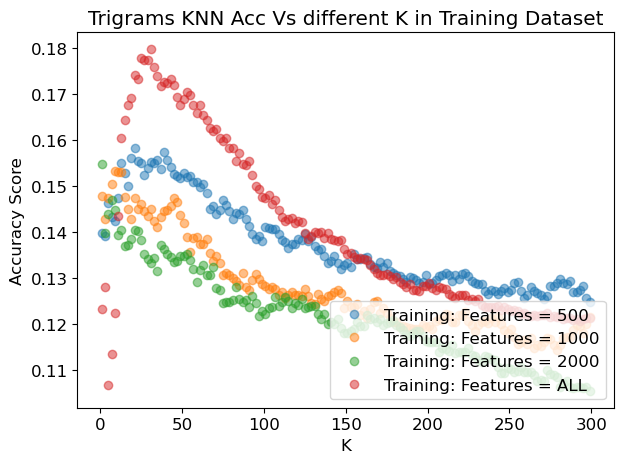

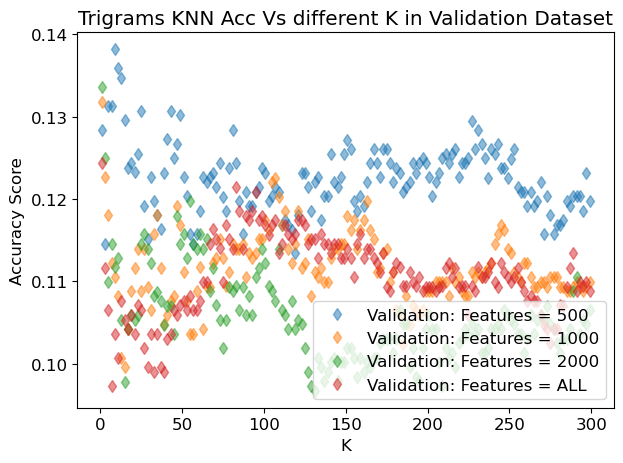

In [25]:
# Unigrams
# change font size
font = {'size'   : 12}

plt.rc('font', **font)

# line graph y=accuracy ; x=k
plt.figure()
for acc_lis in acc_lis_uni_train:
    plt.plot(np.arange(1,max_k,2), acc_lis,'o', alpha=0.5)  
plt.title('Unigrams KNN Acc Vs different K in Training Dataset')
plt.xlabel('K')
plt.ylabel('Accuracy Score')
leg_lis_train = [
           'Training: Features = ' + str(max_feature_lis[0]), 'Training: Features = ' + str(max_feature_lis[1]),
           'Training: Features = ' + str(max_feature_lis[2]), 'Training: Features = ALL' ,
           ]
plt.legend(leg_lis_train,loc='lower right')
plt.savefig("acc_k_uni_train.png", format="png")
plt.show()


plt.figure()
for acc_lis in acc_lis_uni:
    plt.plot(np.arange(1,max_k,2), acc_lis,'d', alpha=0.5)

plt.title('Unigrams KNN Acc Vs different K in Validation Dataset')
plt.xlabel('K')
plt.ylabel('Accuracy Score')
leg_lis_vald = ['Validation: Features = ' + str(max_feature_lis[0]),'Validation: Features = ' + str(max_feature_lis[1]),
           'Validation: Features = ' + str(max_feature_lis[2]),'Validation: Features = ALL',
           ]
plt.legend(leg_lis_vald,loc='lower right')
plt.savefig("acc_k_uni_vald.png", format="png")
plt.show()


# bigrams

# line graph y=accuracy ; x=k
plt.figure()
for acc_lis in acc_lis_bi_train:
    plt.plot(np.arange(1,max_k,2), acc_lis,'o', alpha=0.5)

plt.title('Bigrams KNN Acc Vs different K in Training Dataset')
plt.xlabel('K')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_train,loc='lower right')
plt.savefig("acc_k_bi_train.png", format="png")
plt.show()


plt.figure()
for acc_lis in acc_lis_bi:
    plt.plot(np.arange(1,max_k,2), acc_lis,'d', alpha=0.5)

plt.title('Bigrams KNN Acc Vs different K in Validation Dataset')
plt.xlabel('K')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_vald,loc='lower right')
plt.savefig("acc_k_bi_valid.png", format="png")
plt.show()

# Trigrams

# line graph y=accuracy ; x=k
plt.figure()
for acc_lis in acc_lis_tri_train:
    plt.plot(np.arange(1,max_k,2), acc_lis,'o', alpha=0.5)

plt.title('Trigrams KNN Acc Vs different K in Training Dataset')
plt.xlabel('K')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_train,loc='lower right')
plt.tight_layout()
plt.savefig("acc_k_tri_train.png", format="png")
plt.show()

plt.figure()
for acc_lis in acc_lis_tri:
    plt.plot(np.arange(1,max_k,2), acc_lis,'d', alpha=0.5)

plt.title('Trigrams KNN Acc Vs different K in Validation Dataset')
plt.xlabel('K')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_vald,loc='lower right')
plt.tight_layout()
plt.savefig("acc_k_tri_vald.png", format="png")
plt.show()

## Select best k and best max_features in Logistic Regression

In [20]:
def cv_grid_search_Logistic_Reg(cleanedText_train, cleanedText_test,y_test, max_feature_lis, param_grid,ngrams):
    '''
    This function grid search on max_features of tfidf and different max_ite Gradient Descent in Logis_Reg
    take text as input and output three lists
    '''
    # some list to contain the hyperparameter crosss validation selection result
    # best k for each max_feature numbers
    best_ite = []
    # accuracy score using best k for each max_feature numbers
    best_ite_acc = []
    # accuracy list of different k under current max_feature numbers. In list of list(array)
    acc_lis = []
    
    # Use KNN with Euclidean Distance
    lgr = LogisticRegression()

    for max_fea in max_feature_lis:
        X = tfidf(cleanedText_train, cleanedText_test, maxFeatures = max_fea,ngram =ngrams)
        # 10 fold cross validation, use accuracy as metric since this is balanced dataset
        grid = GridSearchCV(lgr, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
        grid_search = grid.fit(X, y_test)

        ite = grid_search.best_params_
        best_ite.append(ite)
        ite_acc = grid_search.best_score_
        best_ite_acc.append(ite_acc)
        test_acc_lis = grid_search.cv_results_['mean_test_score']
        acc_lis.append(test_acc_lis)

    return best_ite, best_ite_acc, acc_lis

In [21]:
# Using train dataset to pick the best hyperparameter
cleanedText_train = lab_raw_train['cleaned_JD_train']
cleanedText_valid = lab_raw_valid['cleaned_JD_valid']
y_valid = lab_raw_valid['salary_bin']
y_train = lab_raw_train['salary_bin']
# set the max_feature parameter in tfidf creation
# Note: The validation dataset only have 5735 features
max_feature_lis = [500,1000,2000,None]
# set param_grid of max_iteration in logistic regression 
param_grid = {'max_iter': [100, 500, 1000, 5000, 10000]}


# choose max_ite and max_features for unigrams in use validation set
best_ite_uni, best_ite_acc_uni, ite_acc_lis_uni = cv_grid_search_Logistic_Reg(
    cleanedText_train,cleanedText_valid, y_valid, max_feature_lis, param_grid,ngrams=1)

display('Unigram Validation Set:',best_ite_uni,best_ite_acc_uni)

# choose max_ite and max_features for unigrams in use training set
best_ite_uni_train, best_ite_acc_uni_train, ite_acc_lis_uni_train = cv_grid_search_Logistic_Reg(
    cleanedText_train,cleanedText_train, y_train, max_feature_lis, param_grid,ngrams=1)

display('Unigram Training Set:',best_ite_uni_train, best_ite_acc_uni_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


'Unigram Validation Set:'

[{'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}]

[0.21877283901401903,
 0.22165636834761812,
 0.22396186299913629,
 0.23433991096937082]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


'Unigram Training Set:'

[{'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}]

[0.238875, 0.24412499999999998, 0.25399999999999995, 0.2632500000000001]

In [22]:
# choose max_ite and max_features for bigrams in use validation set
best_ite_bi, best_ite_acc_bi, ite_acc_lis_bi = cv_grid_search_Logistic_Reg(
    cleanedText_train,cleanedText_valid, y_valid, max_feature_lis, param_grid,ngrams=2)

display('Bigram Validation Set:',best_ite_bi,best_ite_acc_bi)

# choose max_ite and max_features for bigrams in use training set
best_ite_bi_train, best_ite_acc_bi_train, ite_acc_lis_bi_train = cv_grid_search_Logistic_Reg(
    cleanedText_train,cleanedText_train, y_train, max_feature_lis, param_grid,ngrams=2)

display('Bigram Training Set:',best_ite_bi_train, best_ite_acc_bi_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


'Bigram Validation Set:'

[{'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}]

[0.15887316457378245,
 0.1680652448342303,
 0.1818915686665338,
 0.19110690319580095]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


'Bigram Training Set:'

[{'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}]

[0.20500000000000002, 0.20800000000000002, 0.21787499999999999, 0.258]

In [26]:
# choose max_ite and max_features for trigrams in use validation set
best_ite_tri, best_ite_acc_tri, ite_acc_lis_tri = cv_grid_search_Logistic_Reg(
    cleanedText_train,cleanedText_valid, y_valid, max_feature_lis, param_grid,ngrams=3)

display('Trigram Validation Set:',best_ite_tri,best_ite_acc_tri)

# choose max_ite and max_features for trigrams in use training set
best_ite_tri_train, best_ite_acc_tri_train, ite_acc_lis_tri_train = cv_grid_search_Logistic_Reg(
    cleanedText_train,cleanedText_train, y_train, max_feature_lis, param_grid,ngrams=3)

display('Trigram Training Set:',best_ite_tri_train, best_ite_acc_tri_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


'Trigram Validation Set:'

[{'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}]

[0.13412730051159388,
 0.1427679223971829,
 0.15025911899541558,
 0.14794033619028638]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


'Trigram Training Set:'

[{'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}, {'max_iter': 100}]

[0.162375, 0.17024999999999998, 0.176375, 0.20787500000000003]

### Save Data into CSV

In [ ]:
# Since this code take long time to run, save the output of the code
df = pd.DataFrame({
    'Uni_ite_val': best_ite_uni,
    'Bi_ite_val': best_ite_bi,
    'Tri_ite_val': best_ite_tri,
    'Uni_ite_train':best_ite_uni_train,
    'Bi_ite_train': best_ite_bi_train,
    'Tri_ite_train': best_ite_tri_train,
    'Uni_ite_acc_val': best_ite_acc_uni,
    'Bi_ite_acc_val': best_ite_acc_bi,
    'Tri_ite_acc_val': best_ite_acc_tri,
    'Uni_ite_acc_train': best_ite_acc_uni_train,
    'Bi_ite_acc_train': best_ite_acc_bi_train,
    'Tri_ite_acc_train': best_ite_acc_tri_train,
    'Uni_ite_meanTestScore_val': ite_acc_lis_uni,
    'Bi_ite_meanTestScore_val': ite_acc_lis_bi,
    'Tri_ite_meanTestScore_val': ite_acc_lis_tri,
    'Uni_ite_meanTestScore_train': ite_acc_lis_uni_train,
    'Bi_ite_meanTestScore_train':ite_acc_lis_bi_train,
    'Tri_ite_meanTestScore_train':ite_acc_lis_tri_train,
})
df['Uni_ite_meanTestScore_val'] = df['Uni_ite_meanTestScore_val'].map(lambda x: ','.join(map(str, x)))
df['Bi_ite_meanTestScore_val'] = df['Bi_ite_meanTestScore_val'].map(lambda x: ','.join(map(str, x)))
df['Tri_ite_meanTestScore_val'] = df['Tri_ite_meanTestScore_val'].map(lambda x: ','.join(map(str, x)))
df['Uni_ite_meanTestScore_train'] = df['Uni_ite_meanTestScore_train'].map(lambda x: ','.join(map(str, x)))
df['Bi_ite_meanTestScore_train'] = df['Bi_ite_meanTestScore_train'].map(lambda x: ','.join(map(str, x)))
df['Tri_ite_meanTestScore_train'] = df['Tri_ite_meanTestScore_train'].map(lambda x: ','.join(map(str, x)))

df.to_csv('Lgr_gridSearch.csv')

# When read the data, decode this string as list
#dfn = pd.read_csv("list.csv")
#dfn['alist'] = dfn['alist'].str.split(',')
#dfn['alist'] = dfn['alist'].map(lambda x: list(map(int, x)))

### Plot the accuracy

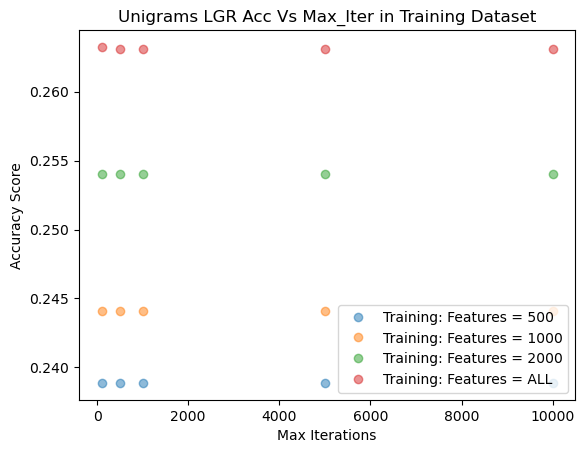

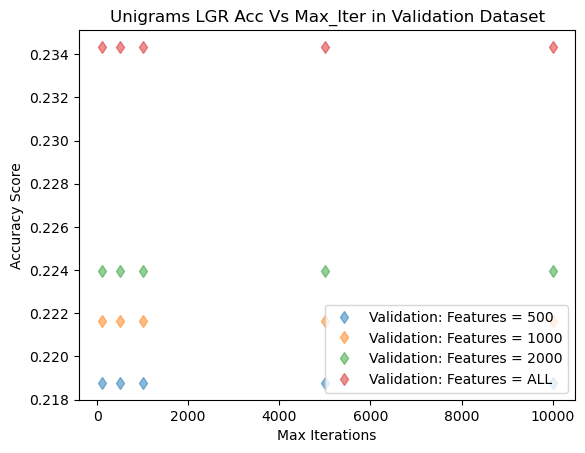

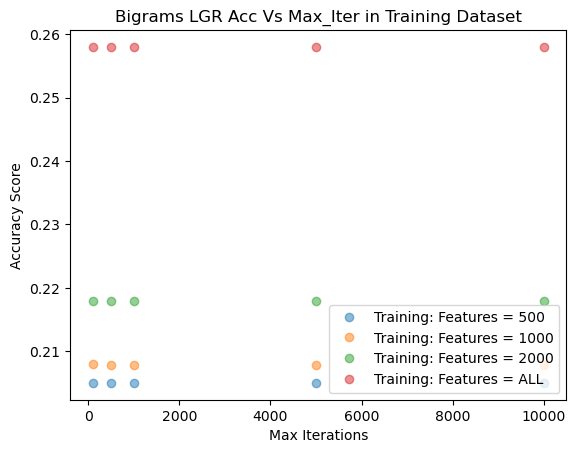

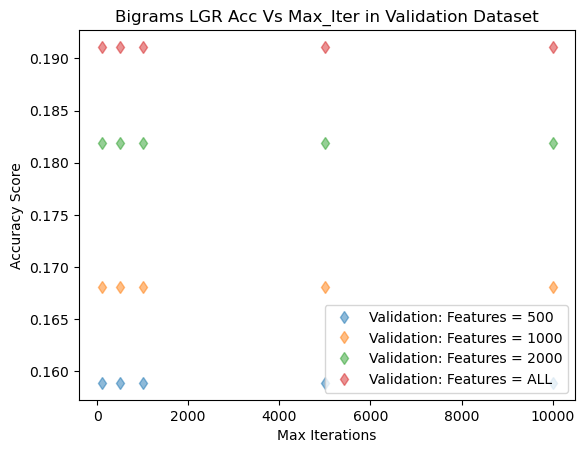

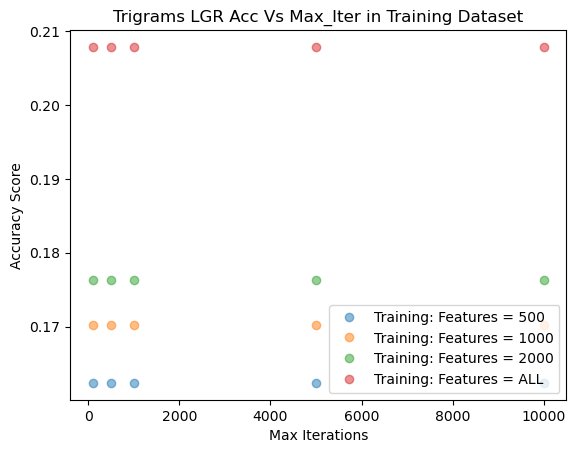

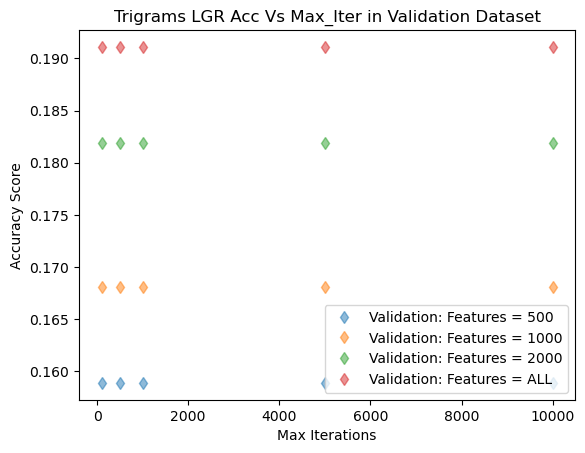

In [ ]:
# Unigrams

# line graph y=accuracy ; x=k
plt.figure()
for acc_lis in ite_acc_lis_uni_train:
    plt.plot(param_grid['max_iter'], acc_lis,'o', alpha=0.5)  
plt.title('Unigrams LGR Acc Vs Max_Iter in Training Dataset')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy Score')
leg_lis_train = [
           'Training: Features = ' + str(max_feature_lis[0]), 'Training: Features = ' + str(max_feature_lis[1]),
           'Training: Features = ' + str(max_feature_lis[2]), 'Training: Features = ALL' ,
           ]
leg_lis_vald = ['Validation: Features = ' + str(max_feature_lis[0]),'Validation: Features = ' + str(max_feature_lis[1]),
           'Validation: Features = ' + str(max_feature_lis[2]),'Validation: Features = ALL',
           ]
plt.legend(leg_lis_train,loc='lower right')
plt.savefig("acc_ite_uni_train.png",  format="png")
plt.show()


plt.figure()
for acc_lis in ite_acc_lis_uni:
    plt.plot(param_grid['max_iter'], acc_lis,'d', alpha=0.5)  
plt.title('Unigrams LGR Acc Vs Max_Iter in Validation Dataset')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_vald,loc='lower right')
plt.savefig("acc_ite_uni_valid.png", format="png")
plt.show()

# bigrams
# line graph y=accuracy ; x=k
plt.figure()
for acc_lis in ite_acc_lis_bi_train:
    plt.plot(param_grid['max_iter'], acc_lis,'o', alpha=0.5)  
plt.title('Bigrams LGR Acc Vs Max_Iter in Training Dataset')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_train,loc='lower right')
plt.savefig("acc_ite_bi_train.png",  format="png")
plt.show()


plt.figure()
for acc_lis in ite_acc_lis_bi:
    plt.plot(param_grid['max_iter'], acc_lis,'d', alpha=0.5)  
plt.title('Bigrams LGR Acc Vs Max_Iter in Validation Dataset')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_vald,loc='lower right')
plt.savefig("acc_ite_bi_valid.png",  format="png")
plt.show()

# trigrams
plt.figure()
for acc_lis in ite_acc_lis_tri_train:
    plt.plot(param_grid['max_iter'], acc_lis,'o', alpha=0.5)  
plt.title('Trigrams LGR Acc Vs Max_Iter in Training Dataset')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_train,loc='lower right')
plt.savefig("acc_ite_tri_train.png",  format="png")
plt.show()


plt.figure()
for acc_lis in ite_acc_lis_bi:
    plt.plot(param_grid['max_iter'], acc_lis,'d', alpha=0.5)  
plt.title('Trigrams LGR Acc Vs Max_Iter in Validation Dataset')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy Score')
plt.legend(leg_lis_vald,loc='lower right')
plt.savefig("acc_ite_tri_valid.png",  format="png")
plt.show()

# Model Training

## KNN

In [27]:
# Use optimal parameter to train the model

# Optimal unigram KNN
cleanedText_train = lab_raw_train['cleaned_JD_train']
y_train = lab_raw_train['salary_bin']
knn_idx_uni = best_k_acc_uni.index(max(best_k_acc_uni))
knn_idx_bi = best_k_acc_bi.index(max(best_k_acc_bi))
knn_idx_tri = best_k_acc_tri.index(max(best_k_acc_tri))

knn_max_features_uni = max_feature_lis[knn_idx_uni]
k_uni = best_k_uni[knn_idx_uni]['n_neighbors']
knn_max_features_bi = max_feature_lis[knn_idx_bi]
k_bi = best_k_bi[knn_idx_bi]['n_neighbors']
knn_max_features_tri = max_feature_lis[knn_idx_tri]
k_tri = best_k_tri[knn_idx_tri]['n_neighbors']

# Unigram, Bigram, Trigram Vectorized Tf-Idf representation for ML
tfidf_uni_train = tfidf(cleanedText_train, cleanedText_test=cleanedText_train,maxFeatures = knn_max_features_uni,ngram=1)
tfidf_bi_train = tfidf(cleanedText_train, cleanedText_test=cleanedText_train, maxFeatures = knn_max_features_bi,ngram=2)
tfidf_tri_train = tfidf(cleanedText_train, cleanedText_test=cleanedText_train, maxFeatures=knn_max_features_tri,ngram=3)

# train KNN model
knn_uni = KNeighborsClassifier(p=2, n_neighbors=k_uni)
knn_bi = KNeighborsClassifier(p=2, n_neighbors=k_bi)
knn_tri = KNeighborsClassifier(p=2, n_neighbors=k_tri)

knn_uni.fit(tfidf_uni_train, y_train)
knn_bi.fit(tfidf_bi_train, y_train)
knn_tri.fit(tfidf_tri_train, y_train)

In [28]:
print('knn_max_features_uni: ',knn_max_features_uni)
print('k_uni: ',k_uni)
print('Num of Features Unigram: ',tfidf_uni_train.shape[1])

print('\nknn_max_features_bi: ',knn_max_features_bi)
print('k_bi: ',k_bi)
print('Num of Features Bigram: ',tfidf_bi_train.shape[1])

print('\nknn_max_features_tri: ', knn_max_features_tri)
print('k_tri: ', k_tri)
print('Num of Features Trigram: ',tfidf_tri_train.shape[1])

knn_max_features_uni:  1000
k_uni:  187
Num of Features Unigram:  1000

knn_max_features_bi:  None
k_bi:  61
Num of Features Bigram:  327596

knn_max_features_tri:  500
k_tri:  9
Num of Features Trigram:  500


## Logistic Regression

In [29]:
# Use optimal parameter to train the model

# Optimal unigram Logistic Regression
cleanedText_train = lab_raw_train['cleaned_JD_train']
y_train = lab_raw_train['salary_bin']
lgr_idx_uni = best_ite_acc_uni.index(max(best_ite_acc_uni))
lgr_idx_bi = best_ite_acc_bi.index(max(best_ite_acc_bi))
lgr_idx_tri = best_ite_acc_tri.index(max(best_ite_acc_tri))

lgr_max_features_uni = max_feature_lis[lgr_idx_uni]
ite_uni = best_ite_uni[lgr_idx_uni]['max_iter']
lgr_max_features_bi = max_feature_lis[lgr_idx_bi]
ite_bi = best_ite_bi[lgr_idx_bi]['max_iter']
lgr_max_features_tri = max_feature_lis[lgr_idx_tri]
ite_tri = best_ite_tri[lgr_idx_tri]['max_iter']

# Unigram, Bigram, Trigram Vectorized Tf-Idf representation for ML
tfidf_uni_train = tfidf(cleanedText_train, cleanedText_test=cleanedText_train,maxFeatures = lgr_max_features_uni,ngram=1)
tfidf_bi_train = tfidf(cleanedText_train, cleanedText_test=cleanedText_train, maxFeatures = lgr_max_features_bi,ngram=2)
tfidf_tri_train = tfidf(cleanedText_train, cleanedText_test=cleanedText_train, maxFeatures=lgr_max_features_tri,ngram=3)

# train logistic regression model
lgr_uni = LogisticRegression(max_iter = ite_uni)
lgr_bi = LogisticRegression(max_iter = ite_bi)
lgr_tri = LogisticRegression(max_iter = ite_tri)

lgr_uni.fit(tfidf_uni_train, y_train)
lgr_bi.fit(tfidf_bi_train, y_train)
lgr_tri.fit(tfidf_tri_train, y_train)

In [30]:
print('lgr_max_features_uni: ',lgr_max_features_uni)
print('ite_uni: ',ite_uni)
print('Num of Features Unigram: ',tfidf_uni_train.shape[1])

print('\nlgr_max_features_bi: ',lgr_max_features_bi)
print('ite_bi: ',ite_bi)
print('Num of Features Bigram: ',tfidf_bi_train.shape[1])

print('\nlgr_max_features_tri: ', lgr_max_features_tri)
print('ite_tri: ', ite_tri)
print('Num of Features Trigram: ',tfidf_tri_train.shape[1])

lgr_max_features_uni:  None
ite_uni:  100
Num of Features Unigram:  6455

lgr_max_features_bi:  None
ite_bi:  100
Num of Features Bigram:  327596

lgr_max_features_tri:  2000
ite_tri:  100
Num of Features Trigram:  2000


# Model Evaluation

## KNN

In [31]:
# Evaluate KNN performance using validation dataset where the model never seen before
cleanedText_valid = lab_raw_valid['cleaned_JD_valid']
y_valid = lab_raw_valid['salary_bin']

# Unigram, Bigram, Trigram Vectorized Tf-Idf representation for ML
knn_tfidf_uni_valid = tfidf(cleanedText_train, cleanedText_valid,maxFeatures = knn_max_features_uni,ngram=1)
knn_tfidf_bi_valid = tfidf(cleanedText_train, cleanedText_valid,maxFeatures = knn_max_features_bi,ngram=2)
knn_tfidf_tri_valid = tfidf(cleanedText_train, cleanedText_valid,maxFeatures = knn_max_features_tri,ngram=3)

# Then produce the classification report
knn_pred_uni = knn_uni.predict(knn_tfidf_uni_valid)
knn_pred_bi = knn_bi.predict(knn_tfidf_bi_valid)
knn_pred_tri = knn_tri.predict(knn_tfidf_tri_valid)

print('\n KNN using Unigram\n',classification_report(y_valid, knn_pred_uni, zero_division=0))
print('\n KNN using Bigram\n',classification_report(y_valid, knn_pred_bi, zero_division=0))
print('\n KNN using Trigram\n',classification_report(y_valid, knn_pred_tri, zero_division=0))

df_knn_uni = pd.DataFrame(classification_report(y_valid, knn_pred_uni, zero_division=0,output_dict=True)).T
df_knn_bi = pd.DataFrame(classification_report(y_valid, knn_pred_bi, zero_division=0,output_dict=True)).T
df_knn_tri = pd.DataFrame(classification_report(y_valid, knn_pred_tri, zero_division=0,output_dict=True)).T

df_knn_uni = df_knn_uni.round(2)
df_knn_bi = df_knn_bi.round(2)
df_knn_tri = df_knn_tri.round(2)


df_knn_uni.to_latex('report_knn_uni.tex')
df_knn_bi.to_latex('report_knn_bi.tex')
df_knn_tri.to_latex('report_knn_tri.tex')


 KNN using Unigram
               precision    recall  f1-score   support

           0       0.40      0.57      0.47       180
           1       0.17      0.14      0.16       142
           2       0.20      0.21      0.21       181
           3       0.25      0.20      0.22       190
           4       0.17      0.09      0.12       201
           5       0.00      0.00      0.00       150
           6       0.20      0.20      0.20       178
           7       0.19      0.18      0.18       171
           8       0.20      0.10      0.13       171
           9       0.22      0.62      0.33       173

    accuracy                           0.23      1737
   macro avg       0.20      0.23      0.20      1737
weighted avg       0.20      0.23      0.21      1737


 KNN using Bigram
               precision    recall  f1-score   support

           0       0.34      0.54      0.42       180
           1       0.17      0.18      0.17       142
           2       0.17      0.27    

## Logistic Regression

In [32]:
# Evaluate logistic regression performance using validation dataset where the model never seen before
cleanedText_valid = lab_raw_valid['cleaned_JD_valid']
y_valid = lab_raw_valid['salary_bin']

# Unigram, Bigram, Trigram Vectorized Tf-Idf representation for ML
lgr_tfidf_uni_valid = tfidf(cleanedText_train, cleanedText_valid,maxFeatures =lgr_max_features_uni,ngram=1)
lgr_tfidf_bi_valid = tfidf(cleanedText_train, cleanedText_valid,maxFeatures = lgr_max_features_bi,ngram=2)
lgr_tfidf_tri_valid = tfidf(cleanedText_train, cleanedText_valid,maxFeatures = lgr_max_features_tri,ngram=3)


# Then produce the classification report
lgr_pred_uni = lgr_uni.predict(lgr_tfidf_uni_valid)
lgr_pred_bi = lgr_bi.predict(lgr_tfidf_bi_valid)
lgr_pred_tri = lgr_tri.predict(lgr_tfidf_tri_valid)

print('\n Logistic Regression using Unigram\n',classification_report(y_valid, lgr_pred_uni, zero_division=0))
print('\n Logistic Regression using Bigram\n',classification_report(y_valid, lgr_pred_bi, zero_division=0))
print('\n Logistic Regression using Trigram\n',classification_report(y_valid, lgr_pred_tri, zero_division=0))

df_lgr_uni = pd.DataFrame(classification_report(y_valid, lgr_pred_uni, zero_division=0,output_dict=True)).T
df_lgr_bi = pd.DataFrame(classification_report(y_valid, lgr_pred_bi, zero_division=0,output_dict=True)).T
df_lgr_tri = pd.DataFrame(classification_report(y_valid, lgr_pred_tri, zero_division=0,output_dict=True)).T

df_lgr_uni = df_lgr_uni.round(2)
df_lgr_bi = df_lgr_bi.round(2)
df_lgr_tri = df_lgr_tri.round(2)

df_lgr_uni.to_latex('report_lgr_uni.tex')
df_lgr_bi.to_latex('report_lgr_bi.tex')
df_lgr_tri.to_latex('report_lgr_tri.tex')


 Logistic Regression using Unigram
               precision    recall  f1-score   support

           0       0.41      0.56      0.47       180
           1       0.23      0.25      0.24       142
           2       0.19      0.17      0.18       181
           3       0.19      0.19      0.19       190
           4       0.17      0.13      0.15       201
           5       0.14      0.05      0.08       150
           6       0.19      0.23      0.21       178
           7       0.21      0.18      0.19       171
           8       0.25      0.18      0.21       171
           9       0.30      0.51      0.38       173

    accuracy                           0.25      1737
   macro avg       0.23      0.24      0.23      1737
weighted avg       0.23      0.25      0.23      1737


 Logistic Regression using Bigram
               precision    recall  f1-score   support

           0       0.39      0.51      0.45       180
           1       0.21      0.20      0.20       142
     

## Baseline Model- Zero R

In [33]:
X = None
y_train = lab_raw_train['salary_bin']
y_test = lab_raw_valid['salary_bin']

zeroR = DummyClassifier(strategy="most_frequent")
zeroR.fit(X, y_train)

zeroR_acc_train = zeroR.score(X, y_train)
zeroR_acc_valid = zeroR.score(X, y_valid)


# Table of Accuracy

Crate two tables: Table 1 for Training Accuracy and Table 2 for Validation Accuracy
Each table is (3*3), three rows are unigrams, bigrams, trigrams; three columns are KNN, LGR, ZeroR; Value inside table is accuracy score

In [36]:

knn_acc_train_uni = max(best_k_acc_uni_train)
knn_acc_train_bi = max(best_k_acc_bi_train)
knn_acc_train_tri = max(best_k_acc_tri_train)

lgr_acc_train_uni = max(best_ite_acc_uni_train)
lgr_acc_train_bi = max(best_ite_acc_bi_train)
lgr_acc_train_tri = max(best_ite_acc_tri_train)

# Get the accuracy score first
knn_acc_valid_uni = max(best_k_acc_uni)
knn_acc_valid_bi = max(best_k_acc_bi)
knn_acc_valid_tri = max(best_k_acc_tri)

lgr_acc_valid_uni = max(best_ite_acc_uni)
lgr_acc_valid_bi = max(best_ite_acc_bi)
lgr_acc_valid_tri = max(best_ite_acc_tri)

train_acc = [[knn_acc_train_uni, lgr_acc_train_uni, zeroR_acc_train], [knn_acc_train_bi, lgr_acc_train_bi, zeroR_acc_train], [knn_acc_train_tri, lgr_acc_train_tri, zeroR_acc_train]]
val_acc = [[knn_acc_valid_uni, lgr_acc_valid_uni, zeroR_acc_valid], [knn_acc_valid_bi, lgr_acc_valid_bi, zeroR_acc_valid], [knn_acc_valid_tri, lgr_acc_valid_tri, zeroR_acc_valid]]

# Table 1: Training Accuracy
train_df = pd.DataFrame(train_acc, index=['Unigrams', 'Bigrams', 'Trigrams'], columns=['KNN', 'LGR', 'ZeroR'])
train_df = train_df.round(2)
print("Training Accuracy:")
print(train_df)

# Table 2: Validation Accuracy
val_df = pd.DataFrame(val_acc, index=['Unigrams', 'Bigrams', 'Trigrams'], columns=['KNN', 'LGR', 'ZeroR'])
val_df = val_df.round(2)
print("\nValidation Accuracy:")
print(val_df)

train_df.to_latex('train_acc_tab.tex')
val_df.to_latex('valid_acc_tab.tex')

Training Accuracy:
           KNN   LGR  ZeroR
Unigrams  0.24  0.26   0.11
Bigrams   0.23  0.26   0.11
Trigrams  0.18  0.21   0.11

Validation Accuracy:
           KNN   LGR  ZeroR
Unigrams  0.23  0.23    0.1
Bigrams   0.19  0.19    0.1
Trigrams  0.14  0.15    0.1


In [35]:
max(best_ite_acc_bi_train)

0.258

# Histogram of Labels

Check whether the dataset is balanced

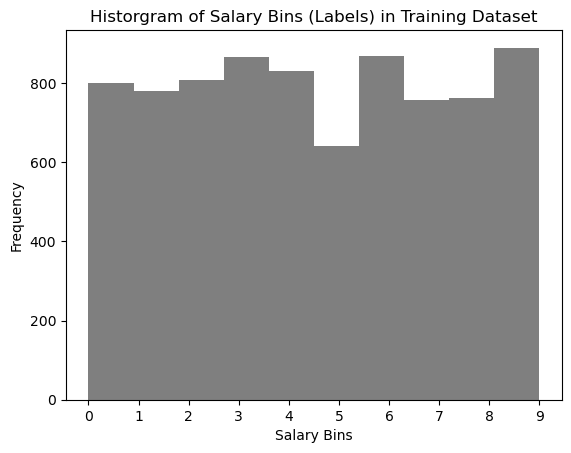

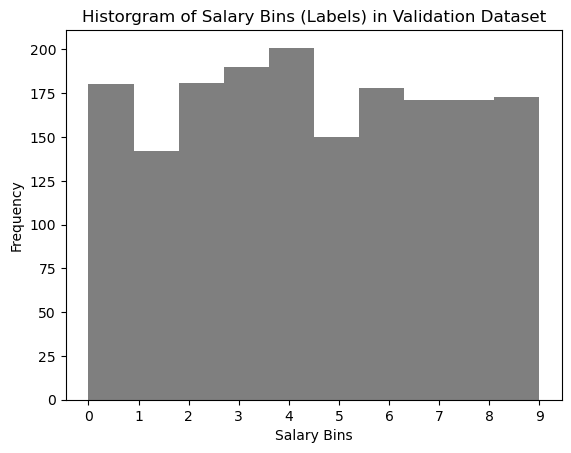

In [ ]:
# histogram salary bin
plt.figure()
plt.hist(lab_raw_train['salary_bin'], alpha=0.5, color='black',bins=10)
plt.title('Historgram of Salary Bins (Labels) in Training Dataset')
plt.xlabel('Salary Bins')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.savefig("hist_label_train.png", dpi=100, format="png")
plt.show()

# histogram salary bin
plt.figure()
plt.hist(lab_raw_valid['salary_bin'], alpha=0.5, color='black',bins=10)
plt.title('Historgram of Salary Bins (Labels) in Validation Dataset')
plt.xlabel('Salary Bins')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.savefig("hist_label_valid.png", dpi=100, format="png")
plt.show()

# Make final prediction using test dataset for Kaggle Competition

In [ ]:
# Use logistic regression and bigrams for prediction
cleanedText_test = raw_test['cleaned_JD_test']

tfidf_uni_test = tfidf(cleanedText_train, cleanedText_test, maxFeatures = lgr_max_features_uni,ngram=1)
tfidf_bi_test = tfidf(cleanedText_train, cleanedText_test, maxFeatures = lgr_max_features_bi,ngram=2)
tfidf_tri_test = tfidf(cleanedText_train, cleanedText_test, maxFeatures = lgr_max_features_tri,ngram=3)

lgr_pred_uni_test = lgr_uni.predict(tfidf_uni_test)
lgr_pred_bi_test = lgr_bi.predict(tfidf_bi_test)
lgr_pred_tri_test = lgr_tri.predict(tfidf_tri_test)

df_test = pd.DataFrame({'job_id':raw_test['job_id'],'salary_bin':lgr_pred_uni_test})
df_test.to_csv('test_pred_lgr_uni.csv', index=False)
df_test = pd.DataFrame({'job_id':raw_test['job_id'],'salary_bin':lgr_pred_bi_test})
df_test.to_csv('test_pred_lgr_bi.csv', index=False)
df_test = pd.DataFrame({'job_id':raw_test['job_id'],'salary_bin':lgr_pred_tri_test})
df_test.to_csv('test_pred_lgr_tri.csv', index=False)

In [ ]:
# Use KNN unigrams for prediction
cleanedText_test = raw_test['cleaned_JD_test']

tfidf_uni_test = tfidf(cleanedText_train, cleanedText_test, maxFeatures = knn_max_features_uni,ngram=1)
tfidf_bi_test = tfidf(cleanedText_train, cleanedText_test, maxFeatures = knn_max_features_bi,ngram=2)
tfidf_tri_test = tfidf(cleanedText_train, cleanedText_test, maxFeatures = knn_max_features_tri,ngram=3)

knn_pred_uni_test = knn_uni.predict(tfidf_uni_test)
knn_pred_bi_test = knn_bi.predict(tfidf_bi_test)
knn_pred_tri_test = knn_tri.predict(tfidf_tri_test)

df_test = pd.DataFrame({'job_id':raw_test['job_id'],'salary_bin':knn_pred_uni_test})
df_test.to_csv('test_pred_knn_uni.csv', index=False)
df_test = pd.DataFrame({'job_id':raw_test['job_id'],'salary_bin':knn_pred_bi_test})
df_test.to_csv('test_pred_knn_bi.csv', index=False)
df_test = pd.DataFrame({'job_id':raw_test['job_id'],'salary_bin':knn_pred_tri_test})
df_test.to_csv('test_pred_knn_tri.csv', index=False)